<i>Updated 19/Nov/2021</i> by Yoshihisa Nitta &nbsp; <img src="https://nw.tsuda.ac.jp/icons/nitta-email.gif" />



# Variational Auto Encoder Analysis for MNIST dataset with Tensorflow 2 on Google Colab

To run this notebook, we assume it is in the state after training with VAE_MNIST_Train.ipynb.


## MNIST データセットを用いて Variational Auto Encoder をGooble Colab 上の Tensorflow 2 で解析する

このノートブックを実行するには VAE_MNIST_Train.ipynb で訓練した後の状態であることを仮定している。

In [1]:
#! pip install tensorflow==2.7.0

In [2]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)

2.7.0


# Check the Google Colab runtime environment

## Google Colab 実行環境を確認する

In [3]:
! nvidia-smi
! cat /proc/cpuinfo
! cat /etc/issue
! free -h

Mon Nov 22 09:20:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive from Google Colab

## Google Colab から GoogleDrive をマウントする

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! ls /content/drive

MyDrive  Shareddrives


# Download source file from Google Drive or nw.tsuda.ac.jp
Basically, <code>gdown</code> from Google Drive. Download from nw.tsuda.ac.jp above only if the specifications of Google Drive change and you cannot download from Google Drive.

## Google Drive または nw.tsuda.ac.jp からファイルをダウンロードする
基本的に Google Drive から <code>gdown</code> してください。 Google Drive の仕様が変わってダウンロードができない場合にのみ、nw.tsuda.ac.jp からダウンロードしてください。

In [6]:
# Download source file
nw_path = './nw'
! rm -rf {nw_path}
! mkdir -p {nw_path}

if True:   # from Google Drive
    url_model =  'https://drive.google.com/uc?id=1ZCihR7JkMOity4wCr66ZCp-3ZOlfwwo3'
    ! (cd {nw_path}; gdown {url_model})
else:      # from nw.tsuda.ac.jp
    URL_NW = 'https://nw.tsuda.ac.jp/lec/GoogleColab/pub'
    url_model = f'{URL_NW}/models/VariationalAutoEncoder.py'
    ! wget -nd {url_model} -P {nw_path}

Downloading...
From: https://drive.google.com/uc?id=1ZCihR7JkMOity4wCr66ZCp-3ZOlfwwo3
To: /content/nw/VariationalAutoEncoder.py
100% 18.7k/18.7k [00:00<00:00, 14.9MB/s]


In [7]:
! cat {nw_path}/VariationalAutoEncoder.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
import datetime

class Sampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0., stddev=1.)
        return mu + tf.keras.backend.exp(log_var / 2) * epsilon


class VAEModel(tf.keras.models.Model):
    def __init__(self, encoder, decoder, r_loss_factor, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.r_loss_factor = r_loss_factor


    @tf.function
    def loss_fn(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.square(x - reconstruction), axis=[1,2,3]
        ) * self.r_loss_factor
        kl_loss = tf.reduce_sum(
   

# Preparing MNIST dataset

## MNIST データセットを用意する

In [8]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np

print(tf.__version__)

2.7.0


In [9]:
# prepare data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test_raw.shape)
print(y_test_raw.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [10]:
x_train = x_train_raw.reshape(x_train_raw.shape+(1,)).astype('float32') / 255.0
x_test = x_test_raw.reshape(x_test_raw.shape+(1,)).astype('float32') / 255.0
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


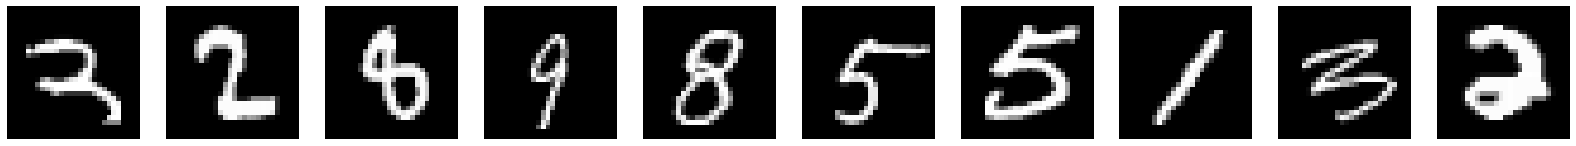

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

N = 10
selected_indices = np.random.choice(x_train_raw.shape[0], N)

fig, ax = plt.subplots(1, N, figsize=(2.8 * N, 2.8))
for i in range(N):
    ax[i].imshow(x_train_raw[selected_indices[i]],cmap='gray')
    ax[i].axis('off')

plt.show()

# Load the Neural Network Model trained before

Use the <code>VariationalAutoEndoer</code> class downloaded from nw.tsuda.ac.jp.
Load the saved weights of the Model.

## 学習済みのニューラルネットワーク・モデルをロードする

nw.tsuda.ac.jp からダウンロードした <code>VariationalAutoEncoder</code> クラスを使う。
ネットワークの重みは、保存したものをロードする。

In [12]:
save_path1 = '/content/drive/MyDrive/ColabRun/VAE01/'
save_path2 = '/content/drive/MyDrive/ColabRun/VAE02/'
save_path3 = '/content/drive/MyDrive/ColabRun/VAE03/'

In [13]:
from nw.VariationalAutoEncoder import VariationalAutoEncoder
import os

vae = VariationalAutoEncoder.load(save_path3)

print(vae.epoch)

200


In [14]:
# [example] load the weights of the specified epoch.
vae_young = VariationalAutoEncoder.load(save_path3, 3)

print(vae_young.epoch)

3


# Display the distribution of points in the latent space.

Encode 10000 images of <code>x_test</code> to generated 2D coordinates and draw as points. The label of the image is expressed by the color of the dots.

## 潜在空間における点の分布を表示する

<code>x_test</code> の10000枚の画像をエンコードして2次元座標を生成し、点として描画する。各画像に描かれている数字は、点の色で表現する。

In [15]:
n_to_show = len(x_test)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test_raw[example_idx]

_, _, z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

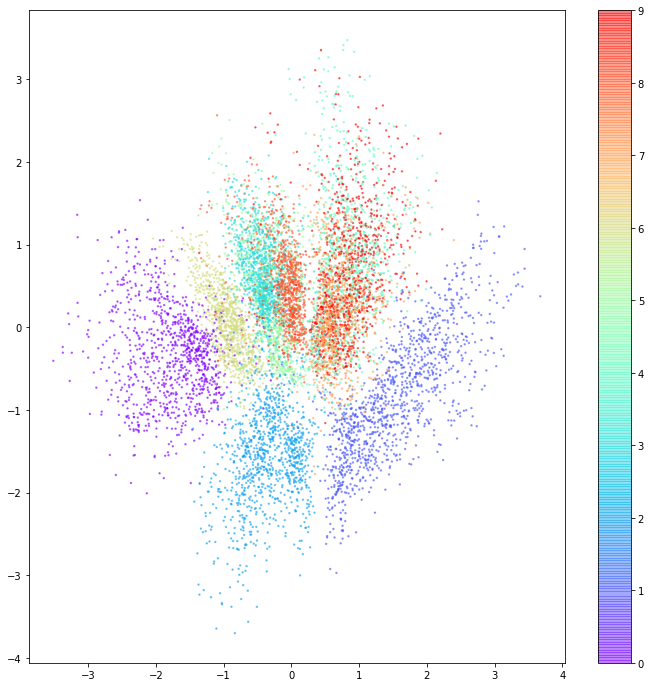

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
map = ax.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow', alpha=0.5, s=2)

plt.colorbar(map)

plt.show()

In [17]:
# Display 30 images as points in the latent space.
# 30 枚の画像を潜在空間の点として表示する。
import numpy as np

table_row = 10    # 表の横方向サイズ
table_line = 3   #表の縦方向サイズ

x = np.random.uniform(min_x, max_x, size=table_line * table_row)
y = np.random.uniform(min_y, max_y, size=table_line * table_row)
z_grid = np.array(list(zip(x,y)))    # (x, y) : 2D coordinates
reconst = vae.decoder.predict(z_grid)

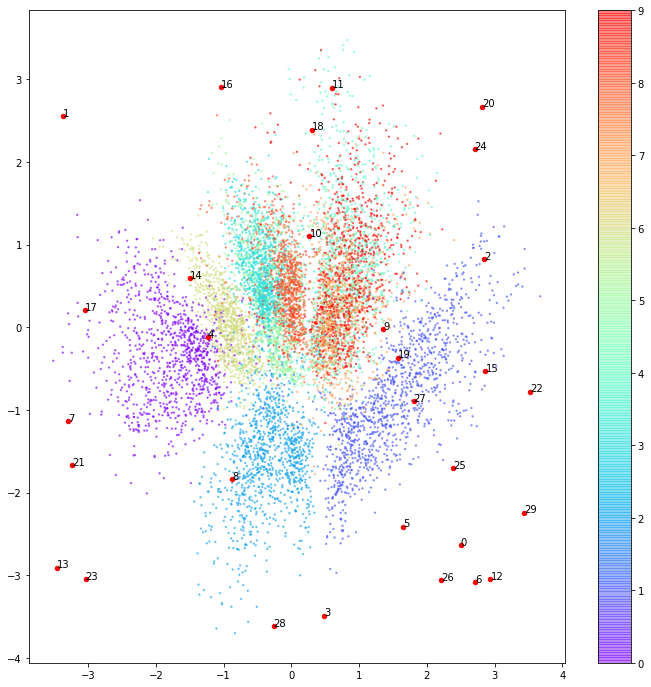

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
map = ax.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow', alpha=0.5, s=2)

ax.scatter(z_grid[:,0], z_grid[:,1], c='red', alpha=1, s=20)

for i in range(len(z_grid)):
    ax.text(z_grid[i][0], z_grid[i][1], str(i))

plt.colorbar(map)

plt.show()

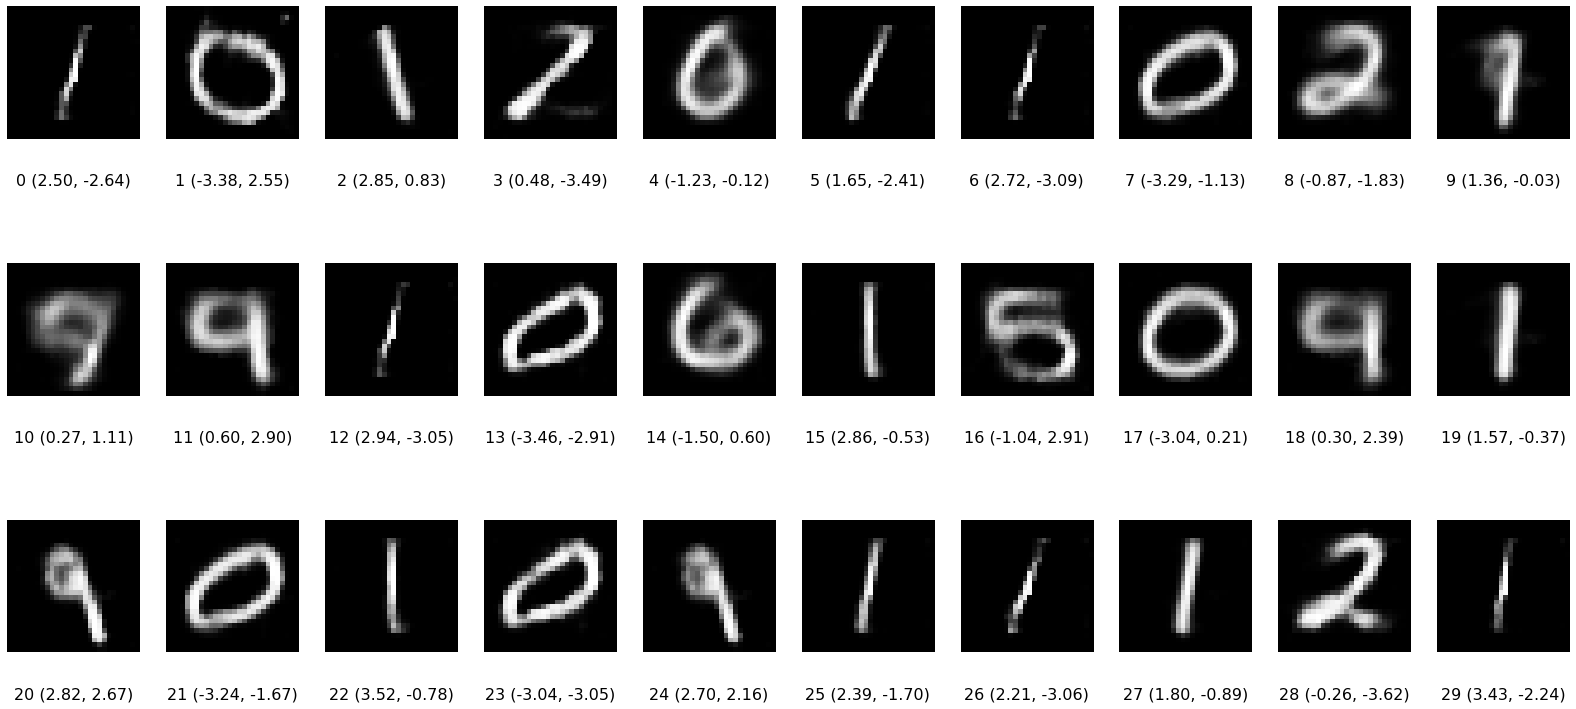

In [19]:
# Display the 30 original images selected as samples.
# サンプルとして選んだ30枚の元画像を表示する
%matplotlib inline
import matplotlib.pyplot as plt

VSKIP=0.5   # vertical space between subplots

fig, ax = plt.subplots(table_line, table_row, figsize=(2.8 * table_row, 2.8 * table_line * (1+VSKIP)))
plt.subplots_adjust(hspace = VSKIP)
                       
for y in range(table_line):
    for x in range(table_row):
        idx = table_row * y + x
        img = reconst[idx].squeeze()
        ax[y][x].imshow(img, cmap='gray')
        ax[y][x].text(0.5, -0.35, f'{idx} ({z_grid[idx][0]:.2f}, {z_grid[idx][1]:.2f})', fontsize=16, ha='center', transform=ax[y][x].transAxes)
        ax[y][x].axis('off')
        
plt.show()

# Divide the latent space into grids and find out what kind of image is generated (decoded) from each coordinates.

Generate images from points on 20x20 grid.
The generated images are displayed as a table with 20 rows and 20 columns.


## 潜在空間をグリッドに区切って、各座標からどのような画像が生成(デコード)されるか調べる

20×20  のグリッドから、画像を生成する。 生成した画像は 20 行 20列の表として表示する。

In [20]:
import numpy as np

n_grid = 20

x = np.linspace(min_x, max_x, n_grid)
y = np.linspace(min_y, max_y, n_grid)

xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid2 = np.array(list(zip(xv, yv)))

reconst2 = vae.decoder.predict(z_grid2)

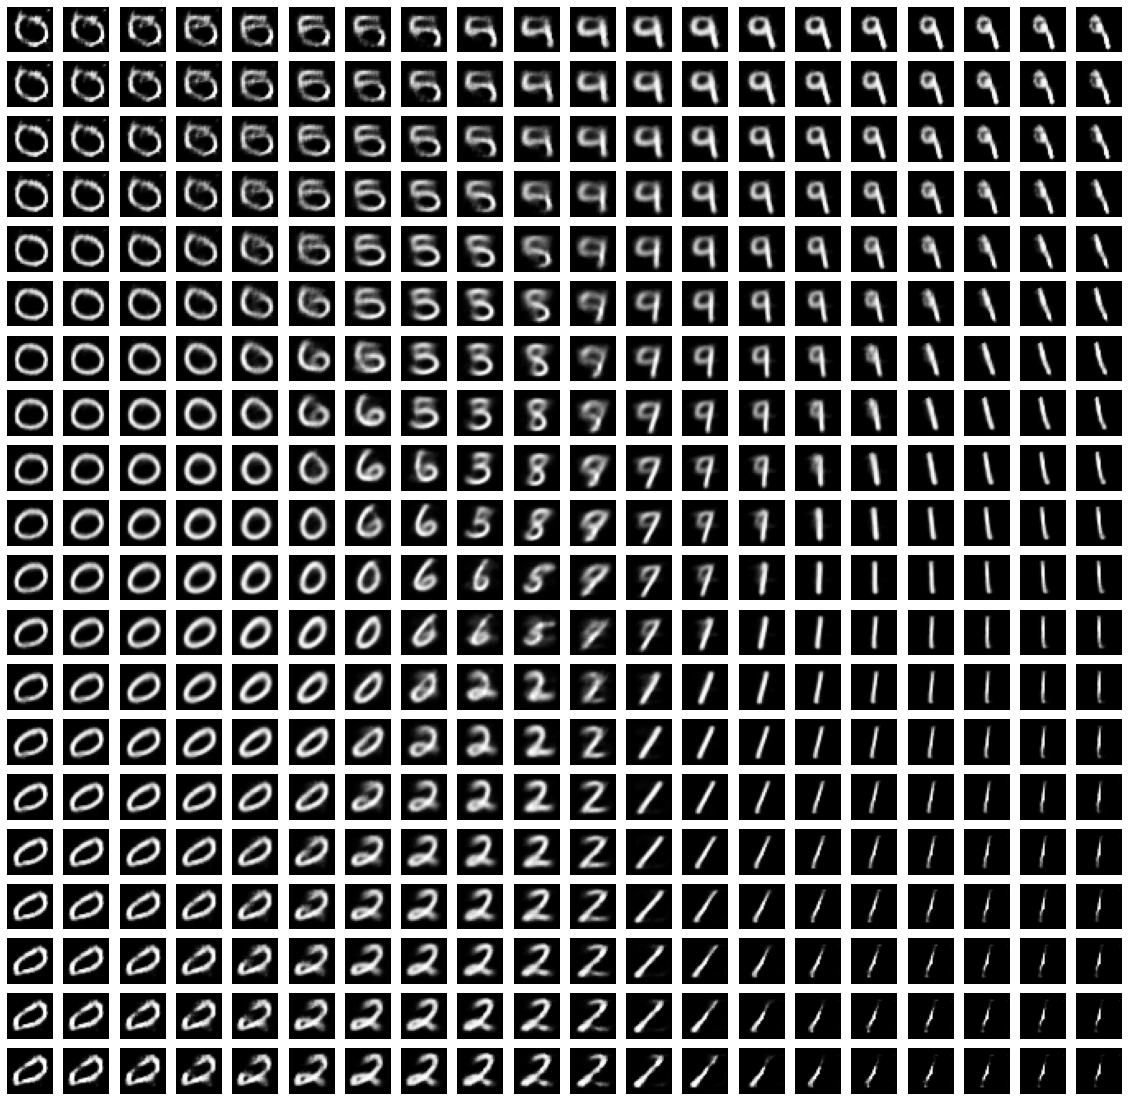

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(n_grid, n_grid, figsize=(n_grid, n_grid))
for i in range(len(reconst2)):
    img = reconst2[i].squeeze()
    line = n_grid - 1 - i // n_grid
    row = i % n_grid
    ax[line][row].imshow(img, cmap='gray')
    ax[line][row].axis('off')
    
plt.show()

# Draw a grid in the latent space.
## グリッドを潜在空間に描画する。

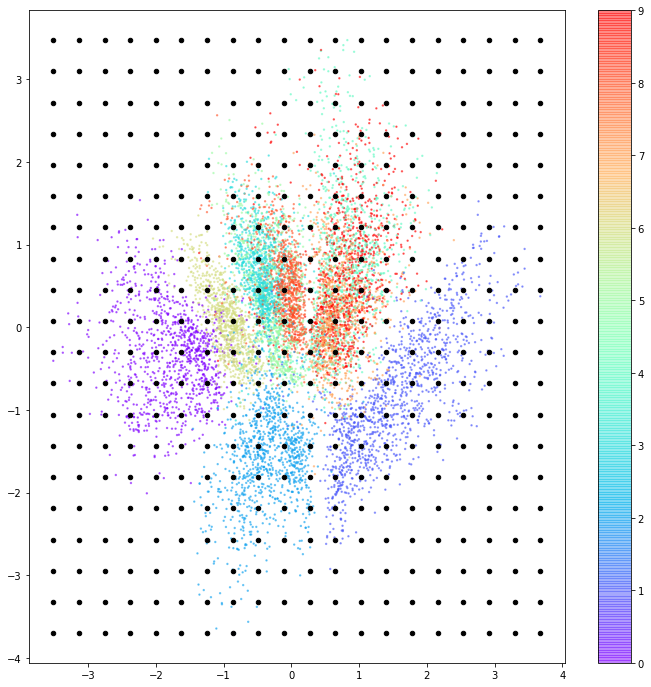

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Encoded 10000 test images for x_test. The points are color-coded with the correct label.
# x_test の10000 個のテスト用画像をエンコードした点。点は正解ラベルで色分けした。
map = ax.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, cmap='rainbow', alpha=0.5, s=2)

# Display the grid as black dots.
# グリッドを黒点として表示する。
ax.scatter(z_grid2[:, 0], z_grid2[:, 1], c='black', alpha=1, s=20)

plt.colorbar(map)   # plt.colorbar() だとエラーになるので注意。pltに対して描画していない場合は、colorbar()の引数にMappableを指定する必要がある。
plt.show()